<a href="https://colab.research.google.com/github/awais546/Intelligent-Cyber-Secuirty/blob/master/AI_Cybersecurity_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5 )
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         # x = x.view(-1, 320)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return x

In [0]:
#lenet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.06)

In [48]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
    print(f"Epoch {epoch+1} Training loss: {running_loss/len(trainloader)}")

print('Finished Training')

Epoch 1 Training loss: 2.3038179871371334
Epoch 2 Training loss: 2.301730412656389
Epoch 3 Training loss: 2.2993701842739758
Epoch 4 Training loss: 2.2961143285722074
Epoch 5 Training loss: 2.291076928148489
Epoch 6 Training loss: 2.2821296340669206
Epoch 7 Training loss: 2.264513625208374
Epoch 8 Training loss: 2.2366026249687994
Epoch 9 Training loss: 2.2011286739803033
Epoch 10 Training loss: 2.158611568038726
Epoch 11 Training loss: 2.111613902746869
Epoch 12 Training loss: 2.071504410270535
Epoch 13 Training loss: 2.0440498951755828
Epoch 14 Training loss: 2.022969053986737
Epoch 15 Training loss: 2.003508359574906
Epoch 16 Training loss: 1.9819018252365423
Epoch 17 Training loss: 1.9586817192299593
Epoch 18 Training loss: 1.9336500443765878
Epoch 19 Training loss: 1.909878593881417
Epoch 20 Training loss: 1.8878779684186286
Finished Training


In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

Files already downloaded and verified


In [0]:
#models is trained. 
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/drive/My Drive/Colab Notebooks/cifar_lenet.pth"
use_cuda=True


In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/cifar_lenet.pth"
torch.save(net.state_dict(), PATH)

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
def test(model, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    
    return final_acc, adv_examples

In [10]:
model_attack = Net()



# Load the pretrained model
model_attack.load_state_dict(torch.load(pretrained_model))
# alex_attack.load_state_dict(alex)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model_attack.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_attack, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    

Epsilon: 0	Test Accuracy = 1478 / 10000 = 0.1478
Epsilon: 0.05	Test Accuracy = 947 / 10000 = 0.0947
Epsilon: 0.1	Test Accuracy = 695 / 10000 = 0.0695
Epsilon: 0.15	Test Accuracy = 447 / 10000 = 0.0447
Epsilon: 0.2	Test Accuracy = 226 / 10000 = 0.0226
Epsilon: 0.25	Test Accuracy = 105 / 10000 = 0.0105
Epsilon: 0.3	Test Accuracy = 47 / 10000 = 0.0047


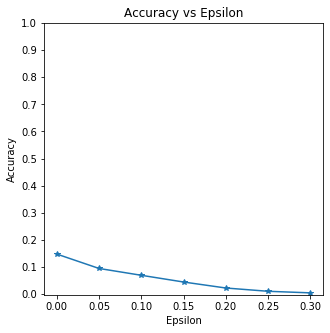

In [16]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [0]:
import numpy 
def convert_to_imshow_format(image):
  # first convert back to [0,1] range from [-1,1] range
  image = image / 2 + 0.5
  image = image.numpy()
  # convert from CHW to HWC
  # from 3x32x32 to 32x32x3
  img = image.transpose(1,2,0)
  
  return img


In [98]:
len(examples[0])

5

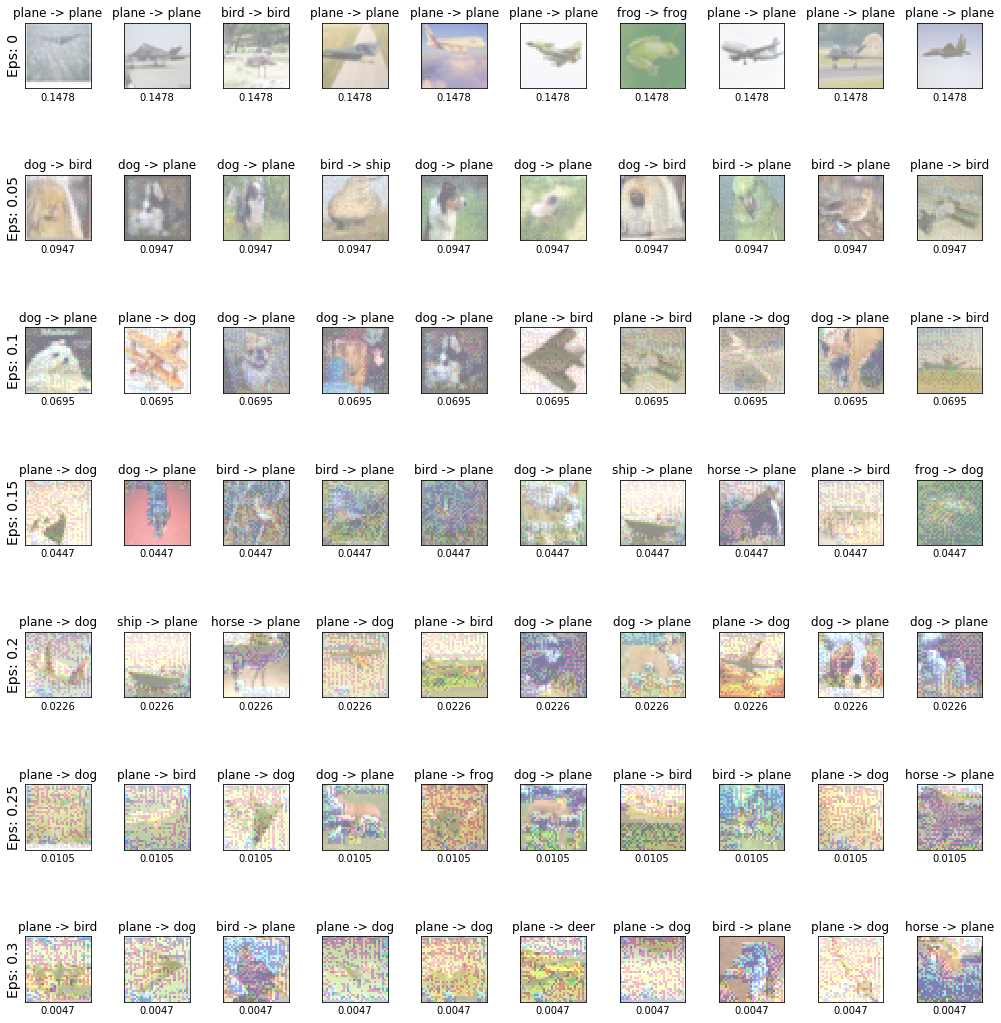

In [21]:

cnt = 0
plt.figure(figsize=(14,15))
li = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.xlabel(accuracies[i])
        plt.title("{} -> {}".format(li[int(orig)], li[int(adv)]))
        
        plt.imshow(convert_to_imshow_format(torch.tensor(ex)))
plt.tight_layout()
plt.show()

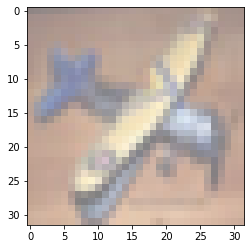

In [89]:
plt.imshow(convert_to_imshow_format(ex1))

In [63]:
!pip install opencv-python

In [0]:
__all__ = ['alexnet']


class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def alexnet(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet(**kwargs)
    return model

In [0]:
# class AlexNet(nn.Module):

#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.classifier = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x
# alex = AlexNet()


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [0]:
alex = models.alexnet(pretrained=True)

In [0]:
# myPath = '/content/drive/My Drive/Data/'
# train_dataset = datasets.CIFAR10(myPath, train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

170500096it [00:05, 28583783.00it/s]                               


Extracting /content/drive/My Drive/Data/cifar-10-python.tar.gz to /content/drive/My Drive/Data/


In [0]:
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True, transform=transform), 
        batch_size=1, shuffle=True)

Files already downloaded and verified


In [0]:
dataiter = next(iter(test_loader))
images, labels = dataiter
alex.eval()

predictions = alex(images)

print(predictions.shape)

torch.Size([1, 1000])


In [0]:
max_value, max_index = torch.max(predictions, dim=1)

In [0]:
print(max_value)
print(max_index)

tensor([8.6836], grad_fn=<MaxBackward0>)
tensor([473])


In [0]:
percentage = torch.nn.functional.softmax(predictions, dim=1)[0] * 100
percentage

tensor([1.0436e-03, 2.6482e-02, 1.5900e-04, 2.2711e-05, 9.0321e-05, 9.0011e-04,
        6.3375e-07, 1.8482e-03, 1.0178e-04, 2.1127e-05, 1.6164e-03, 1.8458e-05,
        1.1301e-04, 1.4182e-05, 2.5153e-05, 8.4674e-05, 1.5491e-03, 8.3408e-06,
        1.0954e-05, 3.4043e-06, 1.1519e-05, 1.4272e-05, 1.6049e-06, 3.6381e-05,
        9.5348e-06, 2.6310e-05, 7.7099e-04, 1.6175e-03, 4.4608e-04, 1.0320e-03,
        4.2385e-05, 3.8499e-05, 1.0852e-03, 4.7619e-05, 9.1142e-05, 1.8017e-05,
        1.0037e-03, 9.9668e-06, 6.5476e-04, 2.7311e-05, 2.0142e-05, 1.8868e-04,
        4.3049e-04, 1.2561e-02, 4.4537e-05, 6.8957e-04, 1.6378e-05, 1.3444e-04,
        8.2177e-05, 3.3538e-05, 1.4015e-06, 1.9173e-01, 7.3836e-05, 1.8783e-04,
        5.1139e-05, 2.9204e-06, 1.8287e-03, 1.6119e-04, 2.8384e-06, 4.6892e-03,
        5.2244e-04, 1.3321e-04, 8.5942e-03, 6.5805e-03, 8.4933e-05, 2.4565e-04,
        6.0889e-04, 1.1581e-05, 3.5171e-03, 3.5322e-05, 8.2182e-05, 4.5227e-04,
        5.3367e-05, 2.1745e-02, 1.8087e-

In [0]:
alex_attack = AlexNet()

In [0]:
# model_attack = Net()



# Load the pretrained model
# model_attack.load_state_dict(torch.load(pretrained_model))
alex_attack.load_state_dict(alex)

# Set the model in evaluation mode. In this case this is for the Dropout layers
alex_attack.eval()

AttributeError: ignored